# <center>VIX Research

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [81]:
import scipy as sp
from numpy.linalg import inv
from matplotlib.mlab import csv2rec
from scipy.optimize import fmin_slsqp
import scipy.optimize as op
from numpy import size, log, pi, sum, diff, array, zeros, diag, dot, mat, asarray, sqrt

## <center>Import Data

In [82]:
# Bloomberg data 
# Create a dict for data storage 
data = pd.ExcelFile('./data/VIX_data.xlsx')
dfs = {sheet_name: data.parse(sheet_name, header=1, index_col='Dates') 
          for sheet_name in data.sheet_names}

# VIX Futures data (1-month, 2-month)
futures = pd.read_excel('./data/VIX_F.xlsx')
futures.set_index('Dates', inplace=True)
dfs['VIX_Futures'] = futures
dfs['VIX_Futures'].sort_values(by='Dates',inplace=True) ## Ascend Date

'''# bloomberg data
data = pd.ExcelFile('./data/VIX_data.xlsx')
dfs = {sheet_name: data.parse(sheet_name, header=1, index_col='Dates') 
          for sheet_name in data.sheet_names}

# VIX Futures data (1-month, 2-month)
futures = pd.read_excel('./data/vix-funds-models-no-formulas.xls')
vix_f = futures[['Date', '1st mth', '2nd mth', 'VIX']]  ## add columns from here
vix_f.set_index('Date', inplace=True)
dfs['VIX_Futures'] = vix_f
dfs['VIX Index'] = pd.DataFrame(dfs['VIX_Futures']['VIX'])
dfs['VIX Index'].rename(columns={'VIX': 'PX_LAST'}, inplace=True)'''

"# bloomberg data\ndata = pd.ExcelFile('./data/VIX_data.xlsx')\ndfs = {sheet_name: data.parse(sheet_name, header=1, index_col='Dates') \n          for sheet_name in data.sheet_names}\n\n# VIX Futures data (1-month, 2-month)\nfutures = pd.read_excel('./data/vix-funds-models-no-formulas.xls')\nvix_f = futures[['Date', '1st mth', '2nd mth', 'VIX']]  ## add columns from here\nvix_f.set_index('Date', inplace=True)\ndfs['VIX_Futures'] = vix_f\ndfs['VIX Index'] = pd.DataFrame(dfs['VIX_Futures']['VIX'])\ndfs['VIX Index'].rename(columns={'VIX': 'PX_LAST'}, inplace=True)"

## <center>Settings

In [83]:
date_from = '2010-12-01'
to_date = '2018-11-27'
for sheet_name in dfs.keys():
    dfs[sheet_name] = dfs[sheet_name].truncate(before=date_from, after=to_date)
    if sheet_name != 'VIX_Futures':
        
        if sheet_name != 'SPVXSPI Index':
            dfs[sheet_name] = pd.merge(dfs['VIX_Futures'], dfs[sheet_name], on='Dates', how='inner')[['PX_OPEN', 'PX_LOW', 'PX_HIGH', 'PX_LAST', 'PX_VOLUME']]
        else:
            dfs[sheet_name] = pd.merge(dfs['VIX_Futures'], dfs[sheet_name], on='Dates', how='inner')[['PX_LAST']]
            
        dfs[sheet_name]['Return'] = dfs[sheet_name]['PX_LAST'].pct_change(periods=1).dropna()

In [84]:
dfs.keys()

dict_keys(['SPX Index', 'SPY US Equity', 'IVOP US Equity', 'SVXY US Equity', 'XIV US Equity', 'XXV US Equity', 'ZIV US Equity', 'VXX US Equity', 'TVIX US Equity', 'UVXY US Equity', 'VXZ US Equity', 'VIXY US Equity', 'VIIX US Equity', 'SPVXSP Index', 'SPVIX2ME Index', 'SPVIX3ME Index', 'SPVIX4ME Index', 'SPVXMP Index', 'SPVIX6ME Index', 'SH US Equity', 'SPVXSPI Index', 'VIX_Futures'])

In [85]:
returns = np.array(dfs['SPX Index']['Return'][1:500])

In [170]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.mlab import csv2rec
from scipy.optimize import fmin_slsqp
from numpy import size, log, pi, sum, diff, array, zeros, diag, dot, mat, asarray, sqrt
#
def gjr_garch_likelihood(parameters, data, sigma2, out=None):
    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    T = size(data,0)
    eps = data-mu
    for t in range(1,T):
        sigma2[t]=(omega+alpha*eps[t-1]**2+gamma*eps[t-1]**2*(eps[t-1]<0)+beta*sigma2[t-1])
    logliks = 0.5*(log(2*pi) + log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)
#
def gjr_constraint(parameters,data, sigma2, out=None):
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    return array([1 - alpha - (gamma/2) - beta]) # Constraint alpha+gamma/2+beta<=1

def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5*np.abs(theta)
    thetah = theta + h
    h = thetah-theta
    K = size(theta,0)
    h = np.diag(h)
    fp = zeros(K)
    fm = zeros(K)
    for i in xrange(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        fpp = zeros((K,K))
        fmm = zeros((K,K))
    for i in xrange(K):
        for j in xrange(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j], *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta-h[i]-h[j], *args)
            fmm[j,i] = fmm[i,j]
            hh = (diag(h))
            hh = hh.reshape((K,1))
            hh = dot(hh,hh.T)
            H = zeros((K,K))
    for i in xrange(K):
        for j in xrange(i,K):
            H[i,j] = (fpp[i,j]-fp[i]-fp[j] + f+ f-fm[i]-fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    return H

def GJR_GARCH(ret):
    import numpy as np
    import scipy.optimize as op
    startV=np.array([ret.mean(),ret.var()*0.01,0.5,0.5,0.5])
    finfo=np.finfo(np.float64)
    t=(0.0,1.0)
    bounds=[(None, None),(None, None),t,t,t]
    T=np.size(ret,0)
    sigma2=np.repeat(ret.var(),T)
    inV=(ret,sigma2)
    return op.fmin_slsqp(gjr_garch_likelihood,startV,f_ieqcons=gjr_constraint,bounds=bounds,args=inV)

In [171]:
tt=GJR_GARCH(returns)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2861.519332570095
            Iterations: 4
            Function evaluations: 42
            Gradient evaluations: 4


In [172]:
tt

array([1.28138156e-02, 1.58086663e+04, 4.99455826e-01, 4.99455769e-01,
       0.00000000e+00])

In [208]:
def HN_garch_lik(parameters, data, sigma2, out=None):
    mu = parameters[0]
    omega = parameters[1]
    beta = parameters[2]
    alpha = parameters[3]
    delta = parameters[4]
    T = size(data,0)
    eps = data-mu
    
    for t in range(1, T):
        sigma2[t] = (omega + beta * sigma2[t-1] + alpha * np.square(eps[t-1] - delta * np.sqrt(sigma2[t-1])))
    logliks = 0.5*(log(2*pi) + log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)
    
    
def hng_constraint(parameters, data, sigma2, out=None):
    beta = parameters[2]
    alpha = parameters[3]
    delta = parameters[4]
    return array([1 - beta - alpha * np.square(delta)])


def HN_garch(ret):
    startV = np.array([ret.mean(), ret.var(), 0.9, 0.1, 50.0])
    # finfo = np.finfo(np.float64)
    bounds = [(ret.mean(), ret.mean()), (None, None), (0.0, 1.0), (0.0, 1.0), (None, None)]
    T = np.size(ret, 0)
    sigma2 = np.repeat(ret.var(), T)
    inV = (ret, sigma2)
    return op.fmin_slsqp(HN_garch_lik, startV, f_ieqcons=hng_constraint, bounds=bounds,args=inV, iter=10000, iprint=3)

In [209]:
returns.mean()

0.00037750509022799097

In [210]:
hng = HN_garch(returns)

  NIT    FC           OBJFUN            GNORM
    1     7              INF              NAN
    2    24              NAN              NAN
    3    41              NAN              NAN
    4    58              NAN              NAN
    5    75              NAN              NAN
    6    92              NAN              NAN
    7   109              NAN              NAN
    8   126              NAN              NAN
    9   143              NAN              NAN
   10   160              NAN              NAN
   11   177              NAN              NAN
   12   194              NAN              NAN
   13   211              NAN              NAN
   14   228              NAN              NAN
   15   245              NAN              NAN
   16   262              NAN              NAN
   17   279              NAN              NAN
   18   296              NAN              NAN
   19   313              NAN              NAN
   20   330              NAN              NAN
   21   347              NAN      

  193  3271              NAN              NAN
  194  3288              NAN              NAN
  195  3305              NAN              NAN
  196  3322              NAN              NAN
  197  3339              NAN              NAN
  198  3356              NAN              NAN
  199  3373              NAN              NAN
  200  3390              NAN              NAN
  201  3407              NAN              NAN
  202  3424              NAN              NAN
  203  3441              NAN              NAN
  204  3458              NAN              NAN
  205  3475              NAN              NAN
  206  3492              NAN              NAN
  207  3509              NAN              NAN
  208  3526              NAN              NAN
  209  3543              NAN              NAN
  210  3560              NAN              NAN
  211  3577              NAN              NAN
  212  3594              NAN              NAN
  213  3611              NAN              NAN
  214  3628              NAN      

  387  6569              NAN              NAN
  388  6586              NAN              NAN
  389  6603              NAN              NAN
  390  6620              NAN              NAN
  391  6637              NAN              NAN
  392  6654              NAN              NAN
  393  6671              NAN              NAN
  394  6688              NAN              NAN
  395  6705              NAN              NAN
  396  6722              NAN              NAN
  397  6739              NAN              NAN
  398  6756              NAN              NAN
  399  6773              NAN              NAN
  400  6790              NAN              NAN
  401  6807              NAN              NAN
  402  6824              NAN              NAN
  403  6841              NAN              NAN
  404  6858              NAN              NAN
  405  6875              NAN              NAN
  406  6892              NAN              NAN
  407  6909              NAN              NAN
  408  6926              NAN      

  575  9765              NAN              NAN
  576  9782              NAN              NAN
  577  9799              NAN              NAN
  578  9816              NAN              NAN
  579  9833              NAN              NAN
  580  9850              NAN              NAN
  581  9867              NAN              NAN
  582  9884              NAN              NAN
  583  9901              NAN              NAN
  584  9918              NAN              NAN
  585  9935              NAN              NAN
  586  9952              NAN              NAN
  587  9969              NAN              NAN
  588  9986              NAN              NAN
  589 10003              NAN              NAN
  590 10020              NAN              NAN
  591 10037              NAN              NAN
  592 10054              NAN              NAN
  593 10071              NAN              NAN
  594 10088              NAN              NAN
  595 10105              NAN              NAN
  596 10122              NAN      

  796 13522              NAN              NAN
  797 13539              NAN              NAN
  798 13556              NAN              NAN
  799 13573              NAN              NAN
  800 13590              NAN              NAN
  801 13607              NAN              NAN
  802 13624              NAN              NAN
  803 13641              NAN              NAN
  804 13658              NAN              NAN
  805 13675              NAN              NAN
  806 13692              NAN              NAN
  807 13709              NAN              NAN
  808 13726              NAN              NAN
  809 13743              NAN              NAN
  810 13760              NAN              NAN
  811 13777              NAN              NAN
  812 13794              NAN              NAN
  813 13811              NAN              NAN
  814 13828              NAN              NAN
  815 13845              NAN              NAN
  816 13862              NAN              NAN
  817 13879              NAN      

 1006 17092              NAN              NAN
 1007 17109              NAN              NAN
 1008 17126              NAN              NAN
 1009 17143              NAN              NAN
 1010 17160              NAN              NAN
 1011 17177              NAN              NAN
 1012 17194              NAN              NAN
 1013 17211              NAN              NAN
 1014 17228              NAN              NAN
 1015 17245              NAN              NAN
 1016 17262              NAN              NAN
 1017 17279              NAN              NAN
 1018 17296              NAN              NAN
 1019 17313              NAN              NAN
 1020 17330              NAN              NAN
 1021 17347              NAN              NAN
 1022 17364              NAN              NAN
 1023 17381              NAN              NAN
 1024 17398              NAN              NAN
 1025 17415              NAN              NAN
 1026 17432              NAN              NAN
 1027 17449              NAN      

 1190 20220              NAN              NAN
 1191 20237              NAN              NAN
 1192 20254              NAN              NAN
 1193 20271              NAN              NAN
 1194 20288              NAN              NAN
 1195 20305              NAN              NAN
 1196 20322              NAN              NAN
 1197 20339              NAN              NAN
 1198 20356              NAN              NAN
 1199 20373              NAN              NAN
 1200 20390              NAN              NAN
 1201 20407              NAN              NAN
 1202 20424              NAN              NAN
 1203 20441              NAN              NAN
 1204 20458              NAN              NAN
 1205 20475              NAN              NAN
 1206 20492              NAN              NAN
 1207 20509              NAN              NAN
 1208 20526              NAN              NAN
 1209 20543              NAN              NAN
 1210 20560              NAN              NAN
 1211 20577              NAN      

 1386 23552              NAN              NAN
 1387 23569              NAN              NAN
 1388 23586              NAN              NAN
 1389 23603              NAN              NAN
 1390 23620              NAN              NAN
 1391 23637              NAN              NAN
 1392 23654              NAN              NAN
 1393 23671              NAN              NAN
 1394 23688              NAN              NAN
 1395 23705              NAN              NAN
 1396 23722              NAN              NAN
 1397 23739              NAN              NAN
 1398 23756              NAN              NAN
 1399 23773              NAN              NAN
 1400 23790              NAN              NAN
 1401 23807              NAN              NAN
 1402 23824              NAN              NAN
 1403 23841              NAN              NAN
 1404 23858              NAN              NAN
 1405 23875              NAN              NAN
 1406 23892              NAN              NAN
 1407 23909              NAN      

 1610 27360              NAN              NAN
 1611 27377              NAN              NAN
 1612 27394              NAN              NAN
 1613 27411              NAN              NAN
 1614 27428              NAN              NAN
 1615 27445              NAN              NAN
 1616 27462              NAN              NAN
 1617 27479              NAN              NAN
 1618 27496              NAN              NAN
 1619 27513              NAN              NAN
 1620 27530              NAN              NAN
 1621 27547              NAN              NAN
 1622 27564              NAN              NAN
 1623 27581              NAN              NAN
 1624 27598              NAN              NAN
 1625 27615              NAN              NAN
 1626 27632              NAN              NAN
 1627 27649              NAN              NAN
 1628 27666              NAN              NAN
 1629 27683              NAN              NAN
 1630 27700              NAN              NAN
 1631 27717              NAN      

 1831 31117              NAN              NAN
 1832 31134              NAN              NAN
 1833 31151              NAN              NAN
 1834 31168              NAN              NAN
 1835 31185              NAN              NAN
 1836 31202              NAN              NAN
 1837 31219              NAN              NAN
 1838 31236              NAN              NAN
 1839 31253              NAN              NAN
 1840 31270              NAN              NAN
 1841 31287              NAN              NAN
 1842 31304              NAN              NAN
 1843 31321              NAN              NAN
 1844 31338              NAN              NAN
 1845 31355              NAN              NAN
 1846 31372              NAN              NAN
 1847 31389              NAN              NAN
 1848 31406              NAN              NAN
 1849 31423              NAN              NAN
 1850 31440              NAN              NAN
 1851 31457              NAN              NAN
 1852 31474              NAN      

 2075 35265              NAN              NAN
 2076 35282              NAN              NAN
 2077 35299              NAN              NAN
 2078 35316              NAN              NAN
 2079 35333              NAN              NAN
 2080 35350              NAN              NAN
 2081 35367              NAN              NAN
 2082 35384              NAN              NAN
 2083 35401              NAN              NAN
 2084 35418              NAN              NAN
 2085 35435              NAN              NAN
 2086 35452              NAN              NAN
 2087 35469              NAN              NAN
 2088 35486              NAN              NAN
 2089 35503              NAN              NAN
 2090 35520              NAN              NAN
 2091 35537              NAN              NAN
 2092 35554              NAN              NAN
 2093 35571              NAN              NAN
 2094 35588              NAN              NAN
 2095 35605              NAN              NAN
 2096 35622              NAN      

 2271 38597              NAN              NAN
 2272 38614              NAN              NAN
 2273 38631              NAN              NAN
 2274 38648              NAN              NAN
 2275 38665              NAN              NAN
 2276 38682              NAN              NAN
 2277 38699              NAN              NAN
 2278 38716              NAN              NAN
 2279 38733              NAN              NAN
 2280 38750              NAN              NAN
 2281 38767              NAN              NAN
 2282 38784              NAN              NAN
 2283 38801              NAN              NAN
 2284 38818              NAN              NAN
 2285 38835              NAN              NAN
 2286 38852              NAN              NAN
 2287 38869              NAN              NAN
 2288 38886              NAN              NAN
 2289 38903              NAN              NAN
 2290 38920              NAN              NAN
 2291 38937              NAN              NAN
 2292 38954              NAN      

 2479 42133              NAN              NAN
 2480 42150              NAN              NAN
 2481 42167              NAN              NAN
 2482 42184              NAN              NAN
 2483 42201              NAN              NAN
 2484 42218              NAN              NAN
 2485 42235              NAN              NAN
 2486 42252              NAN              NAN
 2487 42269              NAN              NAN
 2488 42286              NAN              NAN
 2489 42303              NAN              NAN
 2490 42320              NAN              NAN
 2491 42337              NAN              NAN
 2492 42354              NAN              NAN
 2493 42371              NAN              NAN
 2494 42388              NAN              NAN
 2495 42405              NAN              NAN
 2496 42422              NAN              NAN
 2497 42439              NAN              NAN
 2498 42456              NAN              NAN
 2499 42473              NAN              NAN
 2500 42490              NAN      

 2750 46740              NAN              NAN
 2751 46757              NAN              NAN
 2752 46774              NAN              NAN
 2753 46791              NAN              NAN
 2754 46808              NAN              NAN
 2755 46825              NAN              NAN
 2756 46842              NAN              NAN
 2757 46859              NAN              NAN
 2758 46876              NAN              NAN
 2759 46893              NAN              NAN
 2760 46910              NAN              NAN
 2761 46927              NAN              NAN
 2762 46944              NAN              NAN
 2763 46961              NAN              NAN
 2764 46978              NAN              NAN
 2765 46995              NAN              NAN
 2766 47012              NAN              NAN
 2767 47029              NAN              NAN
 2768 47046              NAN              NAN
 2769 47063              NAN              NAN
 2770 47080              NAN              NAN
 2771 47097              NAN      

 2963 50361              NAN              NAN
 2964 50378              NAN              NAN
 2965 50395              NAN              NAN
 2966 50412              NAN              NAN
 2967 50429              NAN              NAN
 2968 50446              NAN              NAN
 2969 50463              NAN              NAN
 2970 50480              NAN              NAN
 2971 50497              NAN              NAN
 2972 50514              NAN              NAN
 2973 50531              NAN              NAN
 2974 50548              NAN              NAN
 2975 50565              NAN              NAN
 2976 50582              NAN              NAN
 2977 50599              NAN              NAN
 2978 50616              NAN              NAN
 2979 50633              NAN              NAN
 2980 50650              NAN              NAN
 2981 50667              NAN              NAN
 2982 50684              NAN              NAN
 2983 50701              NAN              NAN
 2984 50718              NAN      

 3175 53965              NAN              NAN
 3176 53982              NAN              NAN
 3177 53999              NAN              NAN
 3178 54016              NAN              NAN
 3179 54033              NAN              NAN
 3180 54050              NAN              NAN
 3181 54067              NAN              NAN
 3182 54084              NAN              NAN
 3183 54101              NAN              NAN
 3184 54118              NAN              NAN
 3185 54135              NAN              NAN
 3186 54152              NAN              NAN
 3187 54169              NAN              NAN
 3188 54186              NAN              NAN
 3189 54203              NAN              NAN
 3190 54220              NAN              NAN
 3191 54237              NAN              NAN
 3192 54254              NAN              NAN
 3193 54271              NAN              NAN
 3194 54288              NAN              NAN
 3195 54305              NAN              NAN
 3196 54322              NAN      

 3426 58232              NAN              NAN
 3427 58249              NAN              NAN
 3428 58266              NAN              NAN
 3429 58283              NAN              NAN
 3430 58300              NAN              NAN
 3431 58317              NAN              NAN
 3432 58334              NAN              NAN
 3433 58351              NAN              NAN
 3434 58368              NAN              NAN
 3435 58385              NAN              NAN
 3436 58402              NAN              NAN
 3437 58419              NAN              NAN
 3438 58436              NAN              NAN
 3439 58453              NAN              NAN
 3440 58470              NAN              NAN
 3441 58487              NAN              NAN
 3442 58504              NAN              NAN
 3443 58521              NAN              NAN
 3444 58538              NAN              NAN
 3445 58555              NAN              NAN
 3446 58572              NAN              NAN
 3447 58589              NAN      

KeyboardInterrupt: 

In [196]:
hng

array([nan, nan, nan, nan, nan])

In [15]:
returns

array([ 0.01281849,  0.00260329, -0.00129827, ..., -0.00655489,
        0.01553241,  0.0032617 ])

In [7]:
dfs.keys()

dict_keys(['SPX Index', 'SPY US Equity', 'IVOP US Equity', 'SVXY US Equity', 'XIV US Equity', 'XXV US Equity', 'ZIV US Equity', 'VXX US Equity', 'TVIX US Equity', 'UVXY US Equity', 'VXZ US Equity', 'VIXY US Equity', 'VIIX US Equity', 'SPVXSP Index', 'SPVIX2ME Index', 'SPVIX3ME Index', 'SPVIX4ME Index', 'SPVXMP Index', 'SPVIX6ME Index', 'SH US Equity', 'SPVXSPI Index', 'VIX_Futures'])

In [8]:
capital = 200000
prop = 0.5 # VIX proportion
criterion = 200000
trading_days = len(dfs['SPX Index'])
ticker = ['VXX US Equity', 'ZIV US Equity']

## <center>Constant Rebalance Date

In [13]:
def rebalance_strategy(rebalance_day):
    port_value = pd.DataFrame(np.zeros((trading_days, 2)), columns=ticker)

    for i in range(trading_days):

        if i == 0:
            port_value[ticker[0]][i] = capital * prop
            port_value[ticker[1]][i] = capital * (1 - prop)

        else:
            port_value[ticker[0]][i] = port_value[ticker[0]][i-1] * (1 + dfs[ticker[0]]['Return'][i])
            port_value[ticker[1]][i] = port_value[ticker[1]][i-1] * (1 + dfs[ticker[1]]['Return'][i])

        # Rebalance
        if ((i+1) % rebalance_day) == 0:
            total = port_value[ticker[0]][i] + port_value[ticker[1]][i]
            port_value[ticker[0]][i] = total * prop
            port_value[ticker[1]][i] = total * (1 - prop)
        else:
            continue
    
    return port_value[:]

In [18]:
for day in range(1, 61):
    df = rebalance_strategy(day)
    value = df.iloc[-1][ticker[0]] + df.iloc[-1][ticker[1]]
    
    if value > criterion:    
        print('Rebalance Day : %d day(s)\n' % day)
        print(df)
        print('-------------------------------------------------------------------------')

Rebalance Day : 4 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     135615.693924   73023.835190
4     135465.741640   73703.126680
5     134986.015625   74976.798224
6     134386.358107   76675.026950
7     137069.487442   73806.647084
8     137038.688596   72833.372617
9     136915.648760   72265.629178
10    137531.003486   70724.611272
11    135498.903389   72960.947979
12    135255.096382   74529.113150
13    135011.289375   76509.953367
14    134176.766656   77747.978502
15    137602.591527   74093.703130
16    137759.457552   71663.116043
17    137759.457552   71663.116043
18    137665.401382   69781.371202
19    134300.177161   72315.480010
20    134177.671308   73875.064709
21    134330.687468   74285.481735
22    134269.511979   74942.148977
23    136912.115885   73721.908553
24    136975.258257   72241.235972
25    136249.918229   75046.720864
26    136517.954410   74579.1

Rebalance Day : 13 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    136665.851638   73589.304728
13    136419.501644   75545.166648
14    135576.274577   76767.580348
15    135095.253634   77012.063088
16    135249.261310   74485.741441
17    135249.261310   74485.741441
18    135156.918993   72529.879522
19    135033.743995   71796.431302
20    134910.568998   73344.821988
21    135064.420954   73752.293222
22    135002.911316   74404.247195
23    133709.495985   77093.557334
24    133771.161344   75545.166648
25    137502.136101   74039.611747
26    137772.635694   73578.

Rebalance Day : 24 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    125749.808773   84505.347594
13    125523.135728   86751.336898
14    124747.260547   88155.080214
15    124304.660652   88435.828877
16    124446.367125   85534.759358
17    124446.367125   85534.759358
18    124361.400554   83288.770053
19    124248.064032   82446.524064
20    124134.727510   84224.598930
21    124276.290701   84692.513369
22    124219.694081   85441.176471
23    137513.350468   74045.650252
24    137576.770123   72558.475458
25    136848.244844   75376.280331
26    137117.458076   74906.

Rebalance Day : 32 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    125749.808773   84505.347594
13    125523.135728   86751.336898
14    124747.260547   88155.080214
15    124304.660652   88435.828877
16    124446.367125   85534.759358
17    124446.367125   85534.759358
18    124361.400554   83288.770053
19    124248.064032   82446.524064
20    124134.727510   84224.598930
21    124276.290701   84692.513369
22    124219.694081   85441.176471
23    123029.588955   88529.411765
24    123086.328858   86751.336898
25    122434.536393   90120.320856
26    122675.394413   89558.

Rebalance Day : 40 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    125749.808773   84505.347594
13    125523.135728   86751.336898
14    124747.260547   88155.080214
15    124304.660652   88435.828877
16    124446.367125   85534.759358
17    124446.367125   85534.759358
18    124361.400554   83288.770053
19    124248.064032   82446.524064
20    124134.727510   84224.598930
21    124276.290701   84692.513369
22    124219.694081   85441.176471
23    123029.588955   88529.411765
24    123086.328858   86751.336898
25    122434.536393   90120.320856
26    122675.394413   89558.

Rebalance Day : 52 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    125749.808773   84505.347594
13    125523.135728   86751.336898
14    124747.260547   88155.080214
15    124304.660652   88435.828877
16    124446.367125   85534.759358
17    124446.367125   85534.759358
18    124361.400554   83288.770053
19    124248.064032   82446.524064
20    124134.727510   84224.598930
21    124276.290701   84692.513369
22    124219.694081   85441.176471
23    123029.588955   88529.411765
24    123086.328858   86751.336898
25    122434.536393   90120.320856
26    122675.394413   89558.

Rebalance Day : 56 day(s)

       SH US Equity  XIV US Equity
0     130000.000000   70000.000000
1     128271.582214   74585.561497
2     127988.169267   78890.374332
3     128158.245692   80481.283422
4     128016.539219   81229.946524
5     127563.193129   82633.689840
6     126996.510518   84505.347594
7     126259.751482   85160.427807
8     126231.381531   84037.433155
9     126118.045008   83382.352941
10    126684.870902   81604.278075
11    125976.481817   82727.272727
12    125749.808773   84505.347594
13    125523.135728   86751.336898
14    124747.260547   88155.080214
15    124304.660652   88435.828877
16    124446.367125   85534.759358
17    124446.367125   85534.759358
18    124361.400554   83288.770053
19    124248.064032   82446.524064
20    124134.727510   84224.598930
21    124276.290701   84692.513369
22    124219.694081   85441.176471
23    123029.588955   88529.411765
24    123086.328858   86751.336898
25    122434.536393   90120.320856
26    122675.394413   89558.

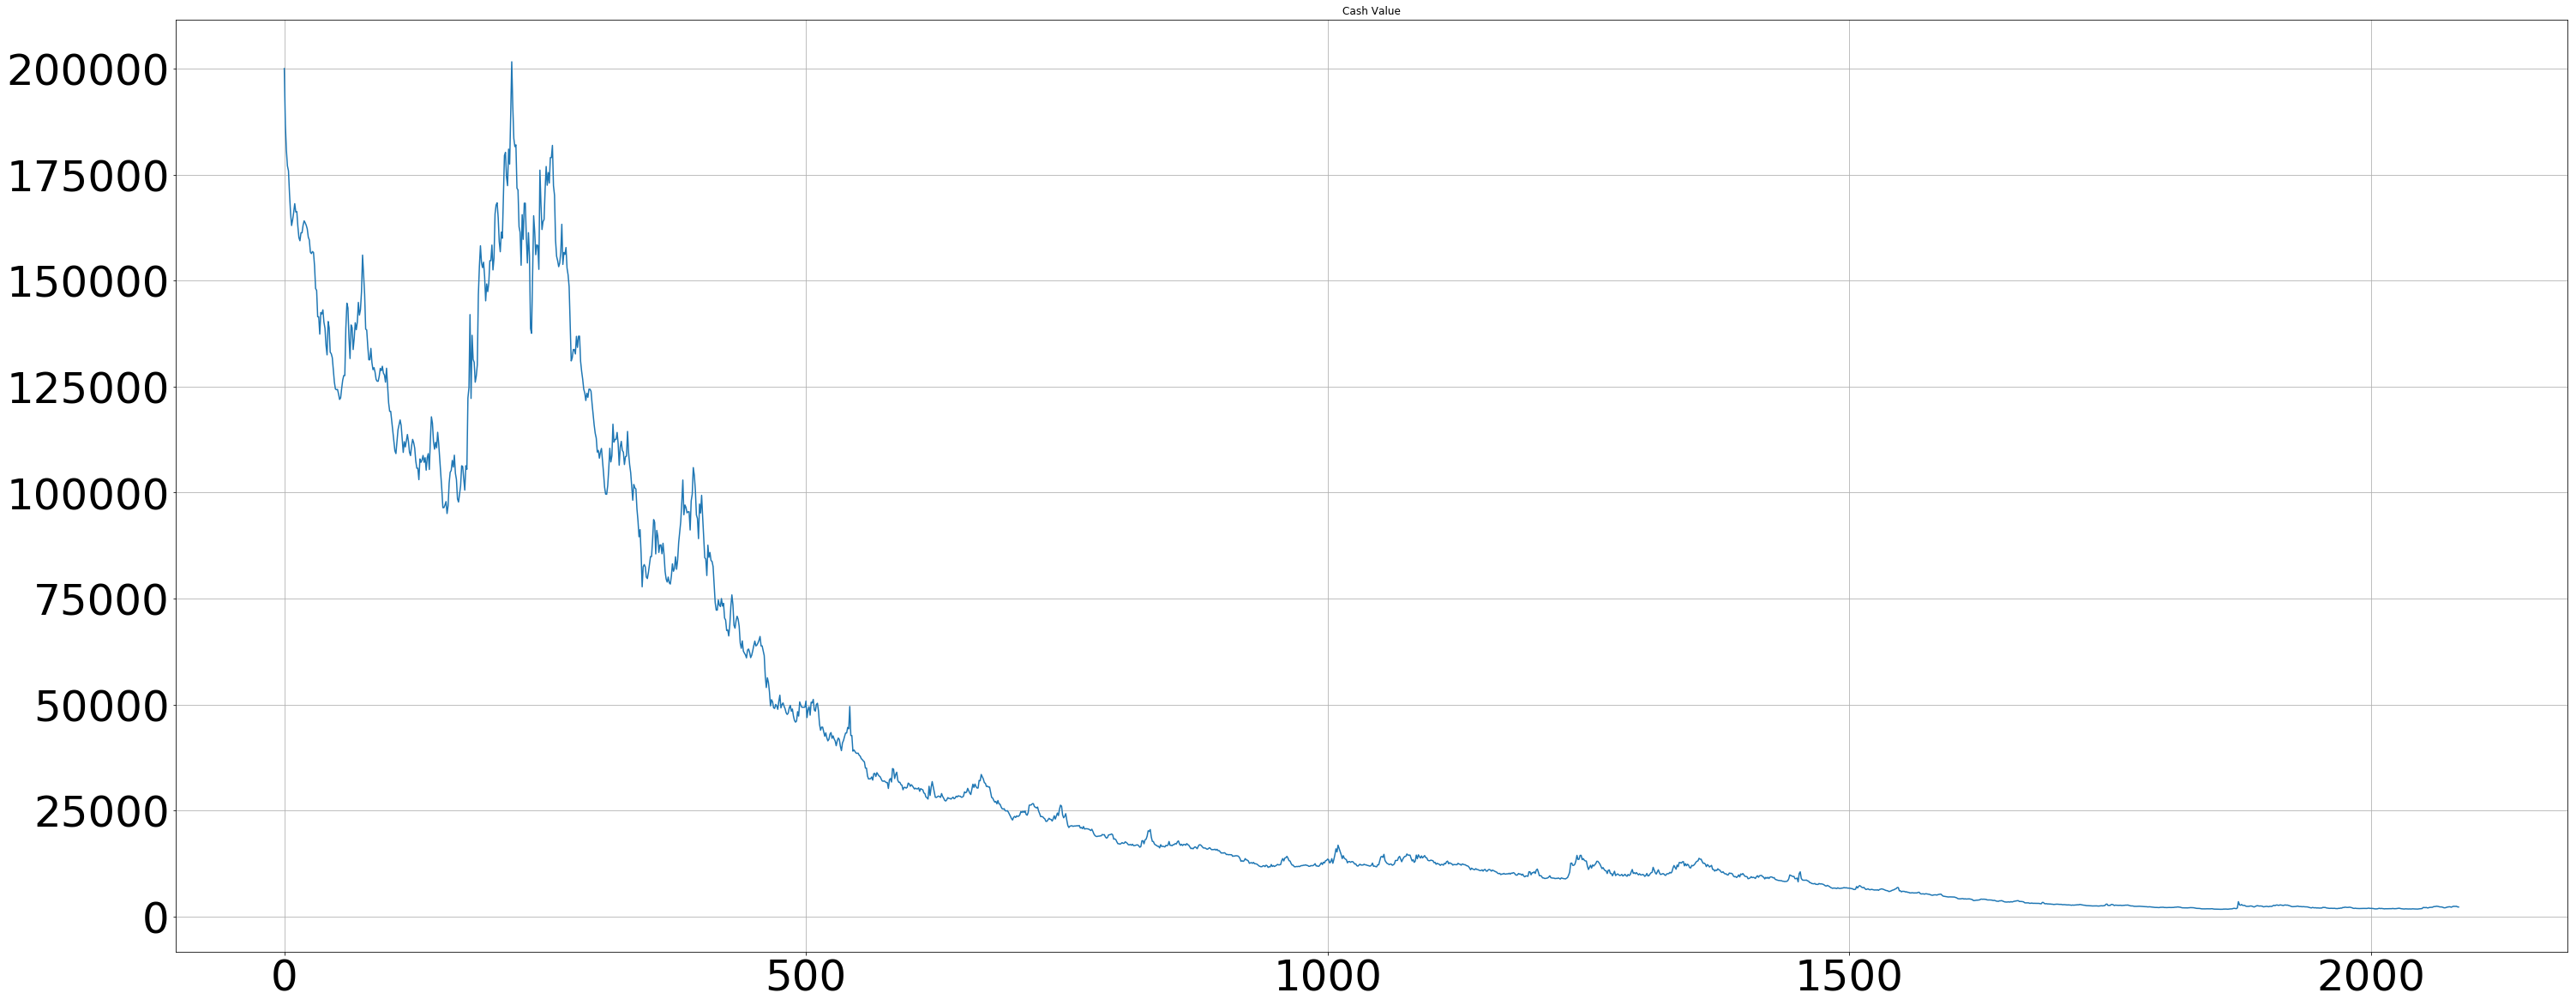

In [133]:
df = rebalance_strategy(20)
df['Total'] = df[ticker[0]] + df[ticker[1]]
df.iloc[:, 2].plot(figsize= (50, 20), title = 'Cash Value', fontsize = 50, grid = True)

## <center>Constant Differential Value Rebalance

In [71]:
def differential_strategy(diff_criterion):
    port_value = pd.DataFrame(np.zeros((trading_days, 2)), columns=ticker)

    for i in range(trading_days):

        if i == 0:
            port_value[ticker[0]][i] = capital * prop
            port_value[ticker[1]][i] = capital * (1 - prop)

        else:
            port_value[ticker[0]][i] = port_value[ticker[0]][i-1] * (1 + dfs[ticker[0]]['Return'][i])
            port_value[ticker[1]][i] = port_value[ticker[1]][i-1] * (1 + dfs[ticker[1]]['Return'][i])

        # Rebalance
        total = port_value[ticker[0]][i] + port_value[ticker[1]][i]
        diff = abs(port_value[ticker[0]][i] - port_value[ticker[1]][i]) / total
        if diff > diff_criterion:
            port_value[ticker[0]][i] = total * prop
            port_value[ticker[1]][i] = total * (1 - prop)
        else:
            continue
    
    return port_value[:]

In [72]:
for dif in np.arange(0.1, 0.35, 0.01):
    df = differential_strategy(dif)
    value = df.iloc[-1][ticker[0]] + df.iloc[-1][ticker[1]]
    if value > criterion:
        print('Differential Value : %f%%\n' % (100*dif))
        print(df)
        print('-------------------------------------------------------------------------')

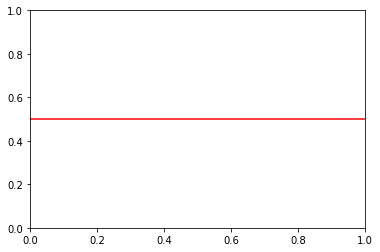

In [73]:
import matplotlib.pyplot as plt
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

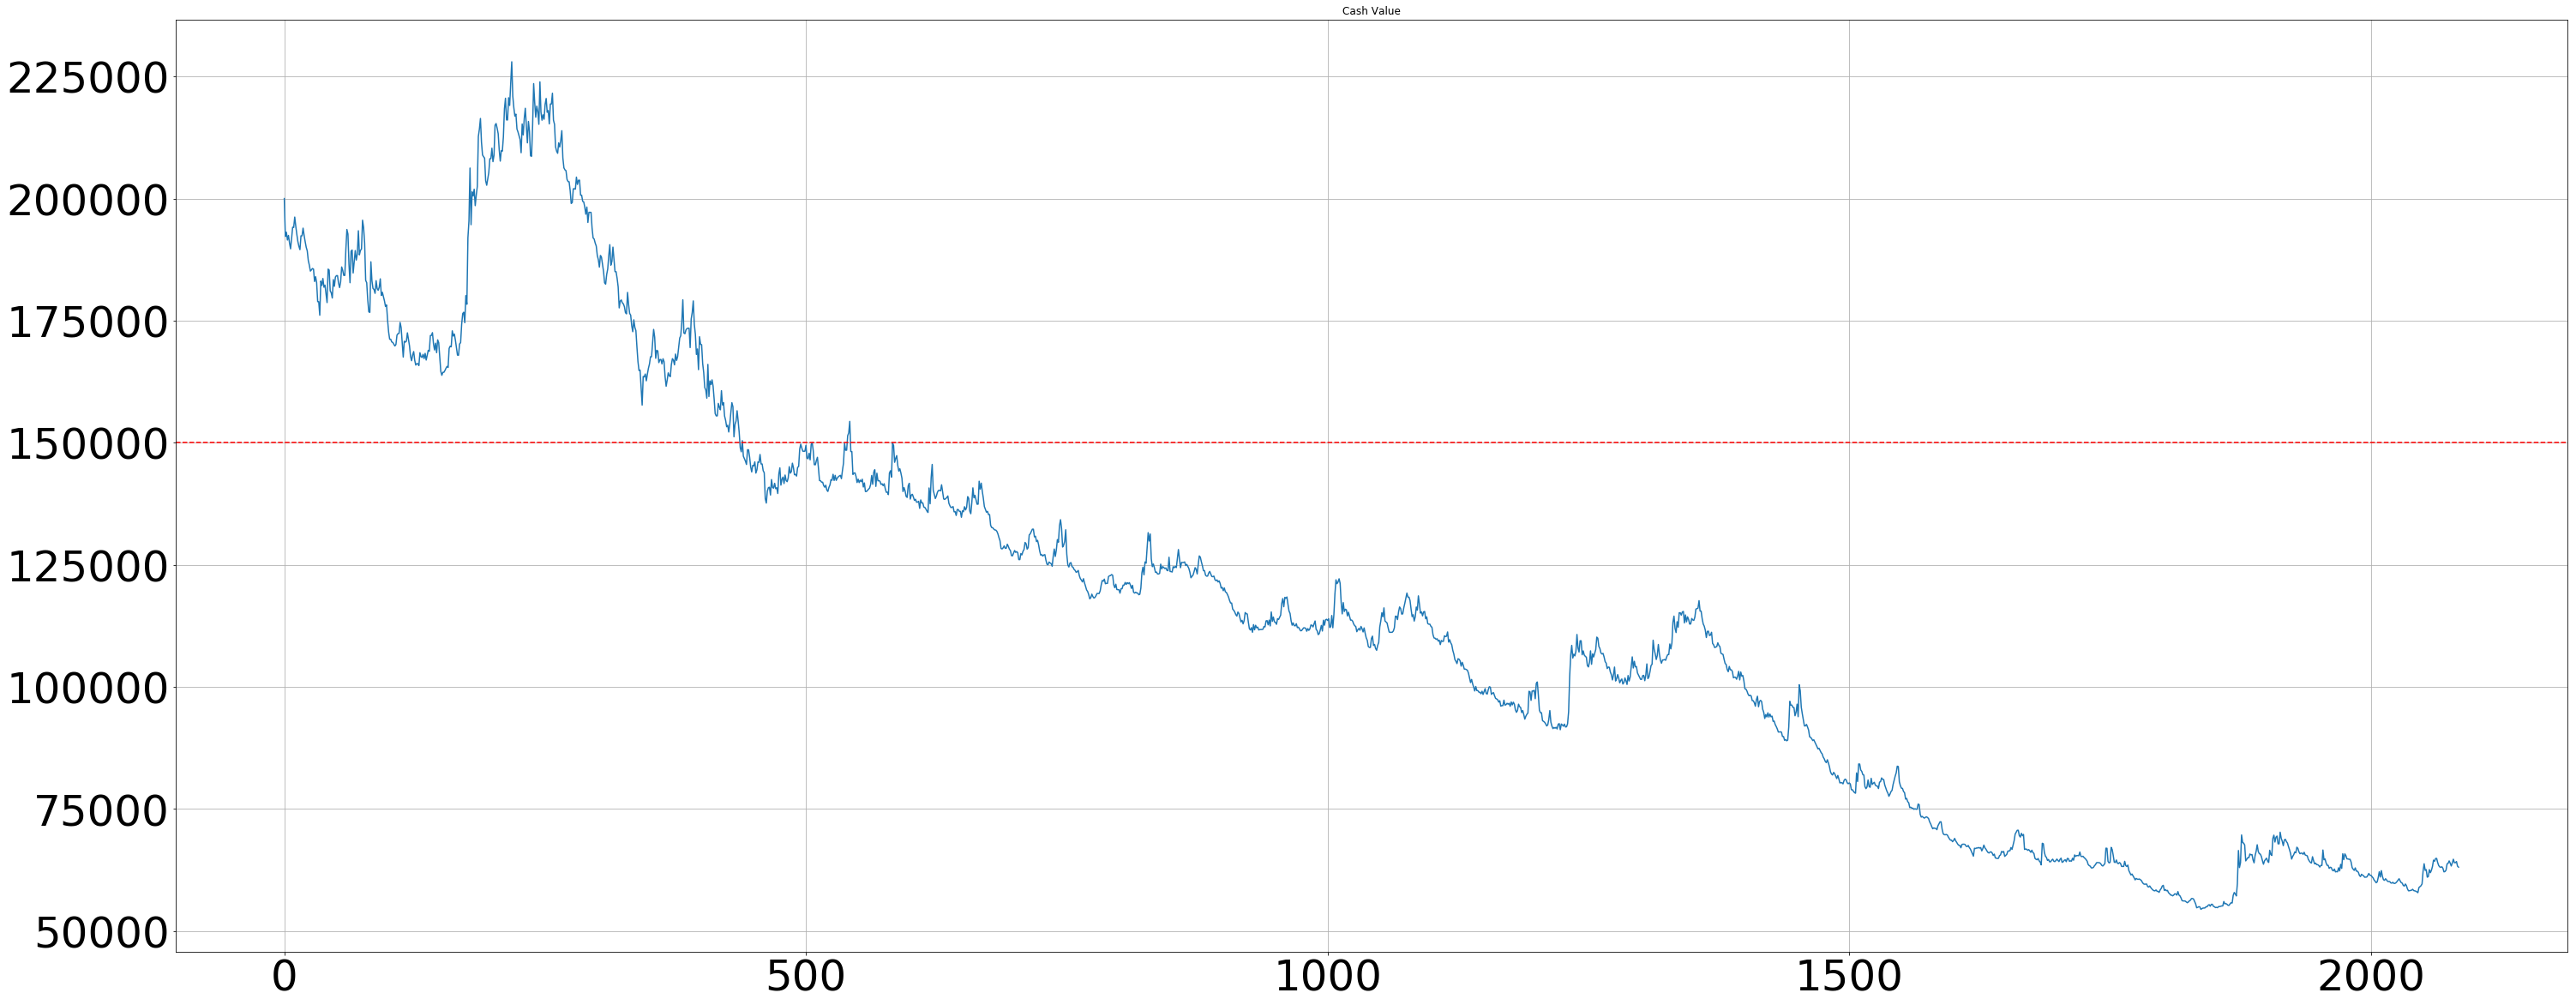

In [83]:
df = differential_strategy(0.10)
df['Total'] = df[ticker[0]] + df[ticker[1]]
df.iloc[:, 2].plot(figsize= (50, 20), title = 'Cash Value', fontsize = 50, grid = True)
plt.gca()
plt.axhline(y=150000, color='r', linestyle='--')

## <center>CB Tree

In [11]:
dfs['VIX_Futures']['Cont2/1']

Dates
2010-12-01    0.1301
2010-12-02    0.1587
2010-12-03    0.1627
2010-12-06    0.1613
2010-12-07    0.1532
2010-12-08    0.1374
2010-12-09    0.1222
2010-12-10    0.1108
2010-12-13    0.1093
2010-12-14    0.0936
2010-12-15    0.0919
2010-12-16    0.1141
2010-12-17    0.1506
2010-12-20    0.1731
2010-12-21    0.1493
2010-12-22    0.1065
2010-12-23    0.0856
2010-12-27    0.0636
2010-12-28    0.0657
2010-12-29    0.0790
2010-12-30    0.0796
2010-12-31    0.0964
2011-01-03    0.1062
2011-01-04    0.1152
2011-01-05    0.1203
2011-01-06    0.1206
2011-01-07    0.1230
2011-01-10    0.1260
2011-01-11    0.1365
2011-01-12    0.1441
               ...  
2018-10-17    0.0029
2018-10-18   -0.0190
2018-10-19   -0.0136
2018-10-22   -0.0215
2018-10-23   -0.0212
2018-10-24   -0.0485
2018-10-25   -0.0526
2018-10-26   -0.0474
2018-10-29   -0.0441
2018-10-30   -0.0335
2018-10-31   -0.0247
2018-11-01   -0.0130
2018-11-02   -0.0255
2018-11-05   -0.0309
2018-11-06   -0.0215
2018-11-07    0.0178
2018-11

In [10]:
capital = 200000
prop = 0.5 # VIX proportion
criterion = 200000
basis_point = dfs['VIX_Futures']['Cont2/1']
spread = 0
fee = 0
 
signals = {'buy_upper': 0.08, 'buy_lower': -0.08, 'sell_upper': 0.06, 'sell_lower': -0.06}

trading_days = len(dfs['SPX Index'])
cont_tickers = ['ZIV US Equity', 'SH US Equity']
back_tickers = ['VXX US Equity', 'SPY US Equity']
proportion = 0.35


In [12]:
def CBT_strategy(trading_days=trading_days, basis=basis_point, signals=signals, cont_tickers=cont_tickers, back_tickers=back_tickers, port=proportion, capital=capital):
    port_value = pd.DataFrame(np.zeros((trading_days, 4)), columns=cont_tickers + back_tickers)
    cash_value = pd.DataFrame(np.zeros(trading_days), columns=['Cash'])
    pos = 0  # {-1: back, 0: nothing, 1:cont}
    
    for i in range(trading_days):
        
        if i != 0:
            port_value[cont_tickers[0]][i] = port_value[cont_tickers[0]][i-1] * (1 + dfs[cont_tickers[0]]['Return'][i])
            port_value[cont_tickers[1]][i] = port_value[cont_tickers[1]][i-1] * (1 + dfs[cont_tickers[1]]['Return'][i])
            port_value[back_tickers[0]][i] = port_value[back_tickers[0]][i-1] * (1 + dfs[back_tickers[0]]['Return'][i])
            port_value[back_tickers[1]][i] = port_value[back_tickers[1]][i-1] * (1 + dfs[back_tickers[1]]['Return'][i])
                
            cash_value.iloc[i] = cash_value.iloc[i-1]
        else:
            cash_value.iloc[0] = capital
        
        if basis.iloc[i] >= signals['buy_upper']:
            if pos == 0:
                port_value[cont_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[cont_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = 1
            elif pos == -1:
                # sell -1
                cash_value.iloc[i] = port_value[back_tickers[0]][i].copy() + port_value[back_tickers[1]][i].copy()
                port_value[back_tickers[0]][i] = 0
                port_value[back_tickers[1]][i] = 0
                # pos = 0
                # buy 1
                port_value[cont_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[cont_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = 1
                
            else:
                pass
        
        elif basis.iloc[i] <= signals['buy_lower']:
            if pos == 0:
                port_value[back_tickers[0]][i] = cash_value.iloc[i] * port
                port_value[back_tickers[1]][i] = cash_value.iloc[i] * (1 - port)
                cash_value.iloc[i] = 0
                pos = -1
            elif pos == 1:
                # sell 1
                cash_value.iloc[i] = port_value[cont_tickers[0]][i].copy() + port_value[cont_tickers[1]][i].copy()
                port_value[cont_tickers[0]][i] = 0
                port_value[cont_tickers[1]][i] = 0
                # pos = 0
                # buy -1
                port_value[back_tickers[0]][i] = cash_value.iloc[i] * port  # VIX
                port_value[back_tickers[1]][i] = cash_value.iloc[i] * (1 - port)  # Inverse_VIX
                cash_value.iloc[i] = 0
                pos = -1
            else:
                pass
                
        elif basis.iloc[i] <= signals['sell_upper'] and basis.iloc[i] >= signals['sell_lower']:
            if pos == 1:
                # sell 1
                cash_value.iloc[i] = port_value[cont_tickers[0]][i].copy() + port_value[cont_tickers[1]][i].copy()
                port_value[cont_tickers[0]][i] = 0
                port_value[cont_tickers[1]][i] = 0
                pos = 0
            elif pos == -1:
                # sell -1
                cash_value.iloc[i] = port_value[back_tickers[0]][i].copy() + port_value[back_tickers[1]][i].copy()
                port_value[back_tickers[0]][i] = 0
                port_value[back_tickers[1]][i] = 0
                pos = 0
            else:
                pass
        #else:
         #   port_value[ticker[0]][i] = port_value[ticker[0]][i-1] * (1 + dfs[ticker[0]]['Return'][i])
          #  port_value[ticker[1]][i] = port_value[ticker[1]][i-1] * (1 + dfs[ticker[1]]['Return'][i])

        # Rebalance
        '''total = port_value[ticker[0]][i] + port_value[ticker[1]][i]
        diff = abs(port_value[ticker[0]][i] - port_value[ticker[1]][i]) / total
        if diff > diff_criterion:
            port_value[ticker[0]][i] = total * prop
            port_value[ticker[1]][i] = total * (1 - prop)
        else:
            continue'''
    return port_value[:], cash_value[:]

In [13]:
d, c= CBT_strategy()

In [14]:
d, c

(      ZIV US Equity   SH US Equity  VXX US Equity  SPY US Equity
 0      70000.000000  130000.000000        0.00000       0.000000
 1      70000.000000  128271.582214        0.00000       0.000000
 2      73596.949016  127988.169267        0.00000       0.000000
 3      73596.949016  128158.245692        0.00000       0.000000
 4      74854.757126  128016.539219        0.00000       0.000000
 5      75718.586913  127563.193129        0.00000       0.000000
 6      75718.586913  126996.510518        0.00000       0.000000
 7      78128.542754  126259.751482        0.00000       0.000000
 8      78894.018466  126231.381531        0.00000       0.000000
 9      78451.706142  126118.045008        0.00000       0.000000
 10     78451.706142  126684.870902        0.00000       0.000000
 11     78451.706142  125976.481817        0.00000       0.000000
 12     78451.706142  125749.808773        0.00000       0.000000
 13     78887.274187  125523.135728        0.00000       0.000000
 14     79